# Access & Subset HyP3 SBAS Stack (InSAR or Burst-InSAR)

*Author: Alex Lewandowski; Alaska Satellite Facility*

This notebook assumes that you have already ordered processing for an InSAR Short Baseline Subset (SBAS) stack using [ASF HyP3](https://hyp3-docs.asf.alaska.edu/), available in a web browser at [ASF Vertex](https://search.asf.alaska.edu/) or programmatically with [hyp3-sdk](https://github.com/ASFHyP3/hyp3-sdk).

---
## 0. Import Required Software 

In [1]:
from pathlib import Path
import sys
from tqdm.auto import tqdm

from hyp3_sdk import Batch, HyP3
from ipyfilechooser import FileChooser
from IPython.display import Markdown, display
import numpy as np
import opensarlab_lib as osl
from osgeo import gdal
gdal.UseExceptions()
from rasterio.warp import transform_bounds

current = Path("..").resolve()
sys.path.append(str(current))
import util.util as util

%matplotlib widget

---

## 1. Select or create a working directory for the analysis

In [2]:
age = osl.select_parameter(
    [
        "Access a new SBAS stack",
        "Add to existing SBAS stack"
    ]
)
display(age)

RadioButtons(layout=Layout(min_width='800px'), options=('Access a new SBAS stack', 'Add to existing SBAS stack…

In [3]:
new = 'new' in age.value

if new:
    print(f'Current working directory: {Path.cwd()}')
    print('Create a new directory to hold your data:')
    data_path = input(f'Enter an unused path for a new data directory:  {Path.home()}/')
    try:
        data_path = Path.home() / data_path.strip()
        data_path.mkdir()
    except:
        raise
else:
    path = Path.home()
    fc = FileChooser(path)
    display(fc)

Current working directory: /home/jovyan/test_MintPy_OpenSARLab/LA2
Create a new directory to hold your data:


Enter an unused path for a new data directory:  /home/jovyan/ la2_test


In [4]:
if not new:
    data_path = Path.home()/fc.selected_path

---

## 2. Migrate SBAS Stack from HyP3

**Create a HyP3 object and authenticate**

In [5]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  vickielee333
NASA Earthdata Login password:  ········


**You may search for InSAR projects in your own account or migrate data from any user's account**

- Retrieving data from another user's account only requires their username and the project name.
- It does **not** require the other user's password. 

In [6]:
hyp3_project = osl.select_parameter(
    [
        'Access InSAR data with any valid HyP3 username and HyP3 Project Name',
        'Search your Projects for available InSAR data'
    ]
)
display(hyp3_project)

RadioButtons(layout=Layout(min_width='800px'), options=('Access InSAR data with any valid HyP3 username and Hy…

**Select your SBAS stack's HyP3 product type**

In [7]:
product_select = osl.select_parameter(
    [
        'INSAR_GAMMA',
        'INSAR_ISCE_BURST'
    ]
)
print("Select your SBAS stack's HyP3 product type")
display(product_select)

Select your SBAS stack's HyP3 product type


RadioButtons(layout=Layout(min_width='800px'), options=('INSAR_GAMMA', 'INSAR_ISCE_BURST'), value='INSAR_GAMMA…

In [8]:
product_type = product_select.value

search = "Search" in hyp3_project.value
if search:
    my_hyp3_info = hyp3.my_info()
    active_projects = dict()
    
    print("Checking all HyP3 projects for current INSAR_GAMMA jobs")
    for project in tqdm(my_hyp3_info['job_names']):
            batch = Batch()
            batch = hyp3.find_jobs(
                name=project, 
                job_type=product_type
            ).filter_jobs(running=False, include_expired=False)
            if len(batch) > 0:
                active_projects.update({batch.jobs[0].name: batch})
    
    if len(active_projects) > 0:
        display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
        display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
        print('\nSelect a Project:')
        project_select = osl.select_parameter(active_projects.keys())
        display(project_select)
    else:
        print("Found no active projects containing InSAR products")
else:
    username = input("enter the HyP3 username on the account containing an SBAS stack to migrate")
    project_name = input("Enter the HyP3 project name")
    batch = Batch()
    batch = hyp3.find_jobs(
        name=project_name, 
        job_type=product_type, 
        user_id=username
    ).filter_jobs(running=False, include_expired=False)

enter the HyP3 username on the account containing an SBAS stack to migrate vickielee333
Enter the HyP3 project name LA2


**Select a date range of products to migrate:**

In [9]:
if search:
    jobs = active_projects[project_select.value]
else:
    jobs = batch

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = osl.get_job_dates(jobs)
date_picker = osl.gui_date_picker(dates)
display(date_picker)

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 780), layout=Layout(width='500px'), options=((' 01/01/2022…

**Save the selected date range and remove products falling outside of it:**

In [10]:
date_range = osl.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
jobs = osl.filter_jobs_by_date(jobs, date_range)

Date Range: 2022-01-01 to 2024-02-20


**Gather the available paths and orbit directions for the remaining products:**

In [11]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
osl.set_paths_orbits(jobs)
paths = set()
orbit_directions = set()
for p in jobs:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

/home/jovyan/.local/envs/opensarlab_mintpy_recipe_book/lib/python3.9/site-packages/tzlocal/unix.py:193: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")


<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

**Select a path:**

- Sentinel-1 has a 12-day repeat cycle so it is not appropriate to merge interferograms across multiple orbital paths. 
- If multiple paths are represented in the SBAS stack, you select one.

In [12]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = osl.select_parameter(paths)
display(path_choice)

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


RadioButtons(layout=Layout(min_width='800px'), options=(64,), value=64)

**Save the selected flight path/s:**

In [13]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: 64


**Select an orbit direction:**

- MintPy is able to decompose 2 Line-Of-Sight (LOS) displacement time series, acquired from different orbit directions, into a vertical displacement time series
- Each LOS time series must be processed individually

In [14]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = osl.select_parameter(orbit_directions, 'Direction:')
display(direction_choice)


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('ASCENDING',), value='ASCEND…

**Save the selected orbit direction:**

In [15]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: ASCENDING


**Filter jobs by path and orbit direction:**

In [16]:
jobs = osl.filter_jobs_by_path(jobs, [flight_path])
jobs = osl.filter_jobs_by_orbit(jobs, direction)
print(f"There are {len(jobs)} products to migrate.")

There are 121 products to migrate.


**Migrate the products, unzip them into a directory named after the product type, and delete the zip files:**

In [17]:
print(f"\nProject: {jobs.jobs[0].name}")
project_zips = jobs.download_files(data_path)
for z in project_zips:
    osl.asf_unzip(str(data_path), str(z))
    z.unlink()


Project: LA2


  0%|          | 0/121 [00:00<?, ?it/s]

S1AA_20220922T015014_20221016T015016_VVP024_INT80_G_ueF_DF51.zip:   0%|          | 0/232107616 [00:00<?, ?it/s…

S1AA_20221028T015016_20221121T015015_VVP024_INT80_G_ueF_9641.zip:   0%|          | 0/229755714 [00:00<?, ?it/s…

S1AA_20230731T015018_20230824T015019_VVP024_INT80_G_ueF_3AA6.zip:   0%|          | 0/230344396 [00:00<?, ?it/s…

S1AA_20230812T015018_20230824T015019_VVP012_INT80_G_ueF_E305.zip:   0%|          | 0/232426126 [00:00<?, ?it/s…

S1AA_20231128T015019_20231222T015018_VVP024_INT80_G_ueF_51BF.zip:   0%|          | 0/231711919 [00:00<?, ?it/s…

S1AA_20230625T015016_20230707T015016_VVP012_INT80_G_ueF_B38F.zip:   0%|          | 0/230137064 [00:00<?, ?it/s…

S1AA_20220525T015008_20220618T015010_VVP024_INT80_G_ueF_8EB9.zip:   0%|          | 0/230180647 [00:00<?, ?it/s…

S1AA_20221215T015014_20221227T015013_VVP012_INT80_G_ueF_0CFA.zip:   0%|          | 0/229195964 [00:00<?, ?it/s…

S1AA_20230613T015015_20230707T015016_VVP024_INT80_G_ueF_168C.zip:   0%|          | 0/231711219 [00:00<?, ?it/s…

S1AA_20231222T015018_20240103T015018_VVP012_INT80_G_ueF_761E.zip:   0%|          | 0/231009037 [00:00<?, ?it/s…

S1AA_20220101T015007_20220113T015007_VVP012_INT80_G_ueF_25E3.zip:   0%|          | 0/231272305 [00:00<?, ?it/s…

S1AA_20220922T015014_20221004T015015_VVP012_INT80_G_ueF_FA1B.zip:   0%|          | 0/232018929 [00:00<?, ?it/s…

S1AA_20230917T015020_20231011T015020_VVP024_INT80_G_ueF_0E6B.zip:   0%|          | 0/230856455 [00:00<?, ?it/s…

S1AA_20230905T015028_20230917T015020_VVP012_INT80_G_ueF_053D.zip:   0%|          | 0/168590314 [00:00<?, ?it/s…

S1AA_20230601T015014_20230613T015015_VVP012_INT80_G_ueF_E9AF.zip:   0%|          | 0/230692271 [00:00<?, ?it/s…

S1AA_20220501T015007_20220513T015008_VVP012_INT80_G_ueF_98B3.zip:   0%|          | 0/230544764 [00:00<?, ?it/s…

S1AA_20230213T015011_20230309T015011_VVP024_INT80_G_ueF_24C3.zip:   0%|          | 0/231800639 [00:00<?, ?it/s…

S1AA_20221109T015015_20221203T015014_VVP024_INT80_G_ueF_CB8A.zip:   0%|          | 0/230962880 [00:00<?, ?it/s…

S1AA_20221121T015015_20221203T015014_VVP012_INT80_G_ueF_30E3.zip:   0%|          | 0/231533301 [00:00<?, ?it/s…

S1AA_20230309T015011_20230402T015012_VVP024_INT80_G_ueF_F21C.zip:   0%|          | 0/232505762 [00:00<?, ?it/s…

S1AA_20230120T015012_20230213T015011_VVP024_INT80_G_ueF_53DC.zip:   0%|          | 0/231512105 [00:00<?, ?it/s…

S1AA_20230402T015012_20230414T015012_VVP012_INT80_G_ueF_CC29.zip:   0%|          | 0/231772418 [00:00<?, ?it/s…

S1AA_20230601T015014_20230625T015016_VVP024_INT80_G_ueF_1C46.zip:   0%|          | 0/230859976 [00:00<?, ?it/s…

S1AA_20230414T015012_20230508T015013_VVP024_INT80_G_ueF_382A.zip:   0%|          | 0/232312704 [00:00<?, ?it/s…

S1AA_20231116T015020_20231210T015019_VVP024_INT80_G_ueF_0F8F.zip:   0%|          | 0/232012205 [00:00<?, ?it/s…

S1AA_20220618T015010_20220712T015012_VVP024_INT80_G_ueF_7399.zip:   0%|          | 0/231899702 [00:00<?, ?it/s…

S1AA_20220314T015005_20220407T015006_VVP024_INT80_G_ueF_A7A4.zip:   0%|          | 0/231114971 [00:00<?, ?it/s…

S1AA_20220326T015006_20220407T015006_VVP012_INT80_G_ueF_2CD8.zip:   0%|          | 0/231130500 [00:00<?, ?it/s…

S1AA_20220407T015006_20220501T015007_VVP024_INT80_G_ueF_BBFF.zip:   0%|          | 0/231976288 [00:00<?, ?it/s…

S1AA_20230426T015012_20230520T015014_VVP024_INT80_G_ueF_D9A3.zip:   0%|          | 0/230325284 [00:00<?, ?it/s…

S1AA_20231116T015020_20231128T015019_VVP012_INT80_G_ueF_A3D7.zip:   0%|          | 0/232311336 [00:00<?, ?it/s…

S1AA_20220407T015006_20220419T015006_VVP012_INT80_G_ueF_1641.zip:   0%|          | 0/231958427 [00:00<?, ?it/s…

S1AA_20220501T015007_20220525T015008_VVP024_INT80_G_ueF_C6C8.zip:   0%|          | 0/232351747 [00:00<?, ?it/s…

S1AA_20221004T015015_20221028T015016_VVP024_INT80_G_ueF_F542.zip:   0%|          | 0/230360310 [00:00<?, ?it/s…

S1AA_20220817T015014_20220910T015015_VVP024_INT80_G_ueF_2210.zip:   0%|          | 0/230757979 [00:00<?, ?it/s…

S1AA_20230321T015011_20230414T015012_VVP024_INT80_G_ueF_6ECB.zip:   0%|          | 0/231098578 [00:00<?, ?it/s…

S1AA_20240115T015017_20240208T015016_VVP024_INT80_G_ueF_05D4.zip:   0%|          | 0/233246983 [00:00<?, ?it/s…

S1AA_20221227T015013_20230108T015013_VVP012_INT80_G_ueF_A100.zip:   0%|          | 0/230544772 [00:00<?, ?it/s…

S1AA_20220101T015007_20220125T015006_VVP024_INT80_G_ueF_F3BD.zip:   0%|          | 0/231125838 [00:00<?, ?it/s…

S1AA_20230613T015015_20230625T015016_VVP012_INT80_G_ueF_AA43.zip:   0%|          | 0/230889432 [00:00<?, ?it/s…

S1AA_20220817T015014_20220829T015014_VVP012_INT80_G_ueF_C638.zip:   0%|          | 0/230138774 [00:00<?, ?it/s…

S1AA_20230213T015011_20230225T015011_VVP012_INT80_G_ueF_1BC9.zip:   0%|          | 0/230995060 [00:00<?, ?it/s…

S1AA_20230707T015016_20230731T015018_VVP024_INT80_G_ueF_1EF7.zip:   0%|          | 0/230222819 [00:00<?, ?it/s…

S1AA_20230309T015011_20230321T015011_VVP012_INT80_G_ueF_0E7C.zip:   0%|          | 0/231894238 [00:00<?, ?it/s…

S1AA_20230414T015012_20230426T015012_VVP012_INT80_G_ueF_DBC2.zip:   0%|          | 0/230077344 [00:00<?, ?it/s…

S1AA_20231011T015020_20231023T015021_VVP012_INT80_G_ueF_6F95.zip:   0%|          | 0/233244141 [00:00<?, ?it/s…

S1AA_20230120T015012_20230201T015012_VVP012_INT80_G_ueF_0B7A.zip:   0%|          | 0/231357023 [00:00<?, ?it/s…

S1AA_20231011T015020_20231104T015020_VVP024_INT80_G_ueF_3C51.zip:   0%|          | 0/231994856 [00:00<?, ?it/s…

S1AA_20230201T015012_20230225T015011_VVP024_INT80_G_ueF_8CB9.zip:   0%|          | 0/232038207 [00:00<?, ?it/s…

S1AA_20221028T015016_20221109T015015_VVP012_INT80_G_ueF_237C.zip:   0%|          | 0/231514869 [00:00<?, ?it/s…

S1AA_20220419T015006_20220501T015007_VVP012_INT80_G_ueF_1E94.zip:   0%|          | 0/230266857 [00:00<?, ?it/s…

S1AA_20221203T015014_20221227T015013_VVP024_INT80_G_ueF_8576.zip:   0%|          | 0/230885931 [00:00<?, ?it/s…

S1AA_20220525T015008_20220606T015010_VVP012_INT80_G_ueF_87C9.zip:   0%|          | 0/230672365 [00:00<?, ?it/s…

S1AA_20221227T015013_20230120T015012_VVP024_INT80_G_ueF_E692.zip:   0%|          | 0/231151013 [00:00<?, ?it/s…

S1AA_20240127T015017_20240220T015016_VVP024_INT80_G_ueF_8C8C.zip:   0%|          | 0/230784333 [00:00<?, ?it/s…

S1AA_20221109T015015_20221121T015015_VVP012_INT80_G_ueF_B5FC.zip:   0%|          | 0/231637525 [00:00<?, ?it/s…

S1AA_20231210T015019_20231222T015018_VVP012_INT80_G_ueF_11E6.zip:   0%|          | 0/232968707 [00:00<?, ?it/s…

S1AA_20231210T015019_20240103T015018_VVP024_INT80_G_ueF_DB45.zip:   0%|          | 0/230861050 [00:00<?, ?it/s…

S1AA_20230929T015020_20231011T015020_VVP012_INT80_G_ueF_CCB0.zip:   0%|          | 0/231713455 [00:00<?, ?it/s…

S1AA_20220712T015012_20220805T015013_VVP024_INT80_G_ueF_6728.zip:   0%|          | 0/229989673 [00:00<?, ?it/s…

S1AA_20220326T015006_20220419T015006_VVP024_INT80_G_ueF_6DB6.zip:   0%|          | 0/230971560 [00:00<?, ?it/s…

S1AA_20221215T015014_20230108T015013_VVP024_INT80_G_ueF_872E.zip:   0%|          | 0/229614350 [00:00<?, ?it/s…

S1AA_20220724T015012_20220817T015014_VVP024_INT80_G_ueF_87E7.zip:   0%|          | 0/231226134 [00:00<?, ?it/s…

S1AA_20220910T015015_20220922T015014_VVP012_INT80_G_ueF_2ACC.zip:   0%|          | 0/233418248 [00:00<?, ?it/s…

S1AA_20230508T015013_20230520T015014_VVP012_INT80_G_ueF_5617.zip:   0%|          | 0/230272637 [00:00<?, ?it/s…

S1AA_20220829T015014_20220910T015015_VVP012_INT80_G_ueF_A96C.zip:   0%|          | 0/232671899 [00:00<?, ?it/s…

S1AA_20221016T015016_20221109T015015_VVP024_INT80_G_ueF_DBB9.zip:   0%|          | 0/232105067 [00:00<?, ?it/s…

S1AA_20230225T015011_20230321T015011_VVP024_INT80_G_ueF_9408.zip:   0%|          | 0/230678895 [00:00<?, ?it/s…

S1AA_20220314T015005_20220326T015006_VVP012_INT80_G_ueF_DFAC.zip:   0%|          | 0/231757900 [00:00<?, ?it/s…

S1AA_20220113T015007_20220206T015006_VVP024_INT80_G_ueF_8CA4.zip:   0%|          | 0/230129057 [00:00<?, ?it/s…

S1AA_20230201T015012_20230213T015011_VVP012_INT80_G_ueF_7ED4.zip:   0%|          | 0/231130621 [00:00<?, ?it/s…

S1AA_20240115T015017_20240127T015017_VVP012_INT80_G_ueF_F014.zip:   0%|          | 0/230883311 [00:00<?, ?it/s…

S1AA_20240127T015017_20240208T015016_VVP012_INT80_G_ueF_A5C1.zip:   0%|          | 0/231809192 [00:00<?, ?it/s…

S1AA_20220218T015005_20220314T015005_VVP024_INT80_G_ueF_7C02.zip:   0%|          | 0/229445762 [00:00<?, ?it/s…

S1AA_20220606T015010_20220630T015011_VVP024_INT80_G_ueF_7FBE.zip:   0%|          | 0/230844269 [00:00<?, ?it/s…

S1AA_20220829T015014_20220922T015014_VVP024_INT80_G_ueF_178D.zip:   0%|          | 0/231344766 [00:00<?, ?it/s…

S1AA_20231023T015021_20231104T015020_VVP012_INT80_G_ueF_7CFF.zip:   0%|          | 0/232278550 [00:00<?, ?it/s…

S1AA_20220618T015010_20220630T015011_VVP012_INT80_G_ueF_F678.zip:   0%|          | 0/230645156 [00:00<?, ?it/s…

S1AA_20230812T015018_20230905T015028_VVP024_INT80_G_ueF_E595.zip:   0%|          | 0/169213864 [00:00<?, ?it/s…

S1AA_20231023T015021_20231116T015020_VVP024_INT80_G_ueF_FE61.zip:   0%|          | 0/231581880 [00:00<?, ?it/s…

S1AA_20220419T015006_20220513T015008_VVP024_INT80_G_ueF_B4E7.zip:   0%|          | 0/231856588 [00:00<?, ?it/s…

S1AA_20230108T015013_20230120T015012_VVP012_INT80_G_ueF_8148.zip:   0%|          | 0/230389177 [00:00<?, ?it/s…

S1AA_20220630T015011_20220712T015012_VVP012_INT80_G_ueF_C9F7.zip:   0%|          | 0/229809714 [00:00<?, ?it/s…

S1AA_20230520T015014_20230613T015015_VVP024_INT80_G_ueF_ADF5.zip:   0%|          | 0/229972121 [00:00<?, ?it/s…

S1AA_20221004T015015_20221016T015016_VVP012_INT80_G_ueF_12DB.zip:   0%|          | 0/231304964 [00:00<?, ?it/s…

S1AA_20220805T015013_20220817T015014_VVP012_INT80_G_ueF_3EEC.zip:   0%|          | 0/230153903 [00:00<?, ?it/s…

S1AA_20240103T015018_20240115T015017_VVP012_INT80_G_ueF_AC12.zip:   0%|          | 0/231067936 [00:00<?, ?it/s…

S1AA_20220630T015011_20220724T015012_VVP024_INT80_G_ueF_A64B.zip:   0%|          | 0/229661668 [00:00<?, ?it/s…

S1AA_20230321T015011_20230402T015012_VVP012_INT80_G_ueF_A42D.zip:   0%|          | 0/230926285 [00:00<?, ?it/s…

S1AA_20220513T015008_20220606T015010_VVP024_INT80_G_ueF_8DE0.zip:   0%|          | 0/230757093 [00:00<?, ?it/s…

S1AA_20220206T015006_20220218T015005_VVP012_INT80_G_ueF_2C19.zip:   0%|          | 0/229527273 [00:00<?, ?it/s…

S1AA_20230824T015019_20230905T015028_VVP012_INT80_G_ueF_3D0A.zip:   0%|          | 0/168594638 [00:00<?, ?it/s…

S1AA_20220910T015015_20221004T015015_VVP024_INT80_G_ueF_53D5.zip:   0%|          | 0/232938239 [00:00<?, ?it/s…

S1AA_20231222T015018_20240115T015017_VVP024_INT80_G_ueF_0858.zip:   0%|          | 0/230455698 [00:00<?, ?it/s…

S1AA_20230520T015014_20230601T015014_VVP012_INT80_G_ueF_0968.zip:   0%|          | 0/229601296 [00:00<?, ?it/s…

S1AA_20230731T015018_20230812T015018_VVP012_INT80_G_ueF_9F8E.zip:   0%|          | 0/230712332 [00:00<?, ?it/s…

S1AA_20230905T015028_20230929T015020_VVP024_INT80_G_ueF_B5A2.zip:   0%|          | 0/168664605 [00:00<?, ?it/s…

S1AA_20230929T015020_20231023T015021_VVP024_INT80_G_ueF_66B5.zip:   0%|          | 0/231559954 [00:00<?, ?it/s…

S1AA_20221121T015015_20221215T015014_VVP024_INT80_G_ueF_6C31.zip:   0%|          | 0/232053794 [00:00<?, ?it/s…

S1AA_20220113T015007_20220125T015006_VVP012_INT80_G_ueF_37B5.zip:   0%|          | 0/228872973 [00:00<?, ?it/s…

S1AA_20230426T015012_20230508T015013_VVP012_INT80_G_ueF_390D.zip:   0%|          | 0/232407104 [00:00<?, ?it/s…

S1AA_20220724T015012_20220805T015013_VVP012_INT80_G_ueF_4A66.zip:   0%|          | 0/230909263 [00:00<?, ?it/s…

S1AA_20230108T015013_20230201T015012_VVP024_INT80_G_ueF_3C38.zip:   0%|          | 0/229416042 [00:00<?, ?it/s…

S1AA_20221203T015014_20221215T015014_VVP012_INT80_G_ueF_2DE9.zip:   0%|          | 0/230464062 [00:00<?, ?it/s…

S1AA_20220125T015006_20220218T015005_VVP024_INT80_G_ueF_ED77.zip:   0%|          | 0/229833301 [00:00<?, ?it/s…

S1AA_20221016T015016_20221028T015016_VVP012_INT80_G_ueF_175A.zip:   0%|          | 0/232174284 [00:00<?, ?it/s…

S1AA_20230225T015011_20230309T015011_VVP012_INT80_G_ueF_2A6A.zip:   0%|          | 0/230319138 [00:00<?, ?it/s…

S1AA_20220606T015010_20220618T015010_VVP012_INT80_G_ueF_833B.zip:   0%|          | 0/230186263 [00:00<?, ?it/s…

S1AA_20220805T015013_20220829T015014_VVP024_INT80_G_ueF_B097.zip:   0%|          | 0/230148959 [00:00<?, ?it/s…

S1AA_20220125T015006_20220206T015006_VVP012_INT80_G_ueF_0DF7.zip:   0%|          | 0/230499596 [00:00<?, ?it/s…

S1AA_20240103T015018_20240127T015017_VVP024_INT80_G_ueF_8500.zip:   0%|          | 0/232317911 [00:00<?, ?it/s…

S1AA_20231104T015020_20231116T015020_VVP012_INT80_G_ueF_8D84.zip:   0%|          | 0/232718214 [00:00<?, ?it/s…

S1AA_20220712T015012_20220724T015012_VVP012_INT80_G_ueF_A7DC.zip:   0%|          | 0/229964196 [00:00<?, ?it/s…

S1AA_20231104T015020_20231128T015019_VVP024_INT80_G_ueF_979E.zip:   0%|          | 0/230961892 [00:00<?, ?it/s…

S1AA_20230508T015013_20230601T015014_VVP024_INT80_G_ueF_ABA3.zip:   0%|          | 0/231430199 [00:00<?, ?it/s…

S1AA_20231128T015019_20231210T015019_VVP012_INT80_G_ueF_D4BF.zip:   0%|          | 0/230757167 [00:00<?, ?it/s…

S1AA_20230824T015019_20230917T015020_VVP024_INT80_G_ueF_E6F3.zip:   0%|          | 0/230632478 [00:00<?, ?it/s…

S1AA_20230917T015020_20230929T015020_VVP012_INT80_G_ueF_4F84.zip:   0%|          | 0/229152886 [00:00<?, ?it/s…

S1AA_20230402T015012_20230426T015012_VVP024_INT80_G_ueF_5AE4.zip:   0%|          | 0/230688733 [00:00<?, ?it/s…

S1AA_20240208T015016_20240220T015016_VVP012_INT80_G_ueF_E43F.zip:   0%|          | 0/232983890 [00:00<?, ?it/s…

S1AA_20220513T015008_20220525T015008_VVP012_INT80_G_ueF_E569.zip:   0%|          | 0/231692982 [00:00<?, ?it/s…

Extracting: /home/jovyan/la2_test/S1AA_20220922T015014_20221016T015016_VVP024_INT80_G_ueF_DF51.zip
Extracting: /home/jovyan/la2_test/S1AA_20221028T015016_20221121T015015_VVP024_INT80_G_ueF_9641.zip
Extracting: /home/jovyan/la2_test/S1AA_20230731T015018_20230824T015019_VVP024_INT80_G_ueF_3AA6.zip
Extracting: /home/jovyan/la2_test/S1AA_20230812T015018_20230824T015019_VVP012_INT80_G_ueF_E305.zip
Extracting: /home/jovyan/la2_test/S1AA_20231128T015019_20231222T015018_VVP024_INT80_G_ueF_51BF.zip
Extracting: /home/jovyan/la2_test/S1AA_20230625T015016_20230707T015016_VVP012_INT80_G_ueF_B38F.zip
Extracting: /home/jovyan/la2_test/S1AA_20220525T015008_20220618T015010_VVP024_INT80_G_ueF_8EB9.zip
Extracting: /home/jovyan/la2_test/S1AA_20221215T015014_20221227T015013_VVP012_INT80_G_ueF_0CFA.zip
Extracting: /home/jovyan/la2_test/S1AA_20230613T015015_20230707T015016_VVP024_INT80_G_ueF_168C.zip
Extracting: /home/jovyan/la2_test/S1AA_20231222T015018_20240103T015018_VVP012_INT80_G_ueF_761E.zip
Extracting

---

## 3. Confirm Presence of a DEM, Azimuth Angle Map, and Incidence Angle Map

- These are optional addon products for HyP3, which are necessary for MintPy
    - Incidence angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected.
    - DEMs are included with HyP3 jobs when the `Include DEM` option is selected
- This is an optional addon product for HyP3, which is necessary for MintPy if running the correct_SET (Solid Earth Tides) step
    - Azimuth angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected

**All of the above mentioned files will be included in an InSAR project if Set MintPy Options is selected when adding InSAR jobs to a project in ASF-Search (Vertex)**

In [18]:
dems = list(data_path.glob('*/*dem*.tif'))
az_angle_maps = list(data_path.glob('*/*lv_phi*.tif'))
inc_angle_maps = list(data_path.glob('*/*lv_theta*.tif'))

if len(dems) > 0:
    print("Success: Found at least 1 DEM.")
else:
    raise FileNotFoundError("Failed to find at least 1 DEM.\n"
                            "You will not be able to successfully run a MintPy time-series unless you"
                            "reorder your HyP3 project with DEMS or provide one from another source.")
                            
if len(az_angle_maps) > 0:
    print("Success: Found at least 1 Azimuth Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Azimuth Angle Map.\n"
                            "You will not be able to successfully run a MintPy time-series unless your"
                            "reorder your HyP3 project with 'Include Look Vectors' option selected.")
    
if len(inc_angle_maps) > 0:
    print("Success: Found at least 1 Incidence Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Incidence Angle Map.\n"
                            "You will not be able to successfully run a MintPy time-series unless your"
                            "reorder your HyP3 project with 'Include Inc. Angle Map' option selected.")

Success: Found at least 1 DEM.
Success: Found at least 1 Azimuth Angle Map.
Success: Found at least 1 Incidence Angle Map.


---
## 4. Subset the Stack

**Project all tiffs to Predominant UTM**

In [19]:
dems.sort()
burst = 'BURST' in product_type
if not burst:
    epsgs = util.get_projections(dems)
    predominant_epsg = None if len(epsgs) == 1 else max(epsgs, key=epsgs.get)
    
    if predominant_epsg:
        for pth in dems:
            src_SRS = util.get_projection(str(pth))
            res = util.get_res(pth)
            if src_SRS != predominant_epsg:
                res = util.get_res(pth)
                no_data_val = util.get_no_data_val(pth)
        
                temp = pth.parent/f"temp_{pth.stem}.tif"
                pth.rename(temp)
    
                warp_options = {
                    "dstSRS":f"EPSG:{predominant_epsg}", "srcSRS":f"EPSG:{src_SRS}",
                    "targetAlignedPixels":True,
                    "xRes":res, "yRes":res,
                    "dstNodata": no_data_val
                }
                gdal.Warp(str(pth), str(temp), **warp_options)
                temp.unlink()


**Determine the maximum and common extents of the stack and plot an Area-of_Interest Selector:**

Maximum Extents: [-13228915.81210509, 3763265.45863514, -12874745.91563535, 4060869.7979775993]
Pixels in this area are guaranteed to be included in at least one interferogram in the stack.


Common Extents: [-13228135.738714725, 3829173.661251133, -12887318.18595182, 4060481.943916891]
Pixels in this area are guaranteed to included in every interferogram in the stack.


Select an AOI inside the common area covered by the stack.


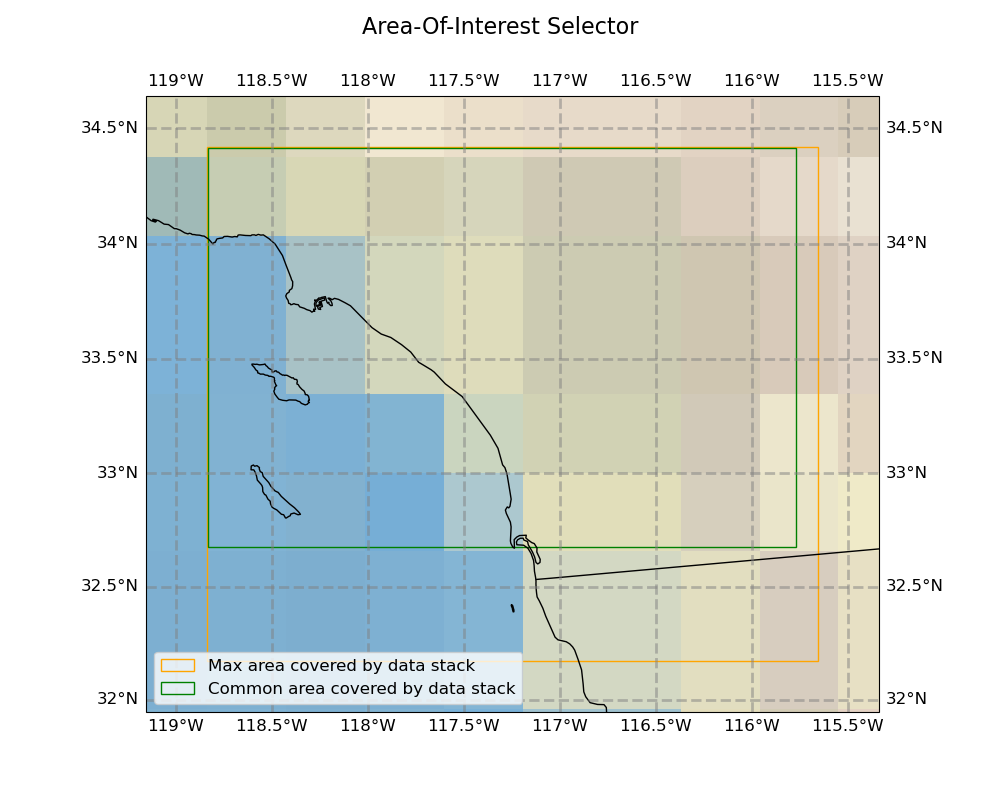

In [20]:
max_extents = osl.get_max_extents(dems)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(dems[0]))), 3857, *max_extents)
max_extents = [xmin, ymin, xmax, ymax]

common_extents = osl.get_common_coverage_extents(dems)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(dems[0]))), 3857, *common_extents)
common_extents = [xmin, ymin, xmax, ymax]

print(f"Maximum Extents: {max_extents}")
print("Pixels in this area are guaranteed to be included in at least one interferogram in the stack.\n\n")

print(f"Common Extents: {common_extents}")
print("Pixels in this area are guaranteed to included in every interferogram in the stack.\n\n")

print(f"Select an AOI inside the common area covered by the stack.")

aoi = osl.AOI_Selector(max_extents, common_extents, figsize=(10, 8))

**Convert the subset corner coordinates from Web-Mercator back to the input data's EPSG:** 

In [21]:
try:
    xmin, ymin, xmax, ymax = transform_bounds(3857, 
                                          int(osl.get_projection(str(dems[0]))), 
                                          *[aoi.x1, aoi.y1, aoi.x2, aoi.y2])
    ul = [xmin, ymax]
    lr = [xmax, ymin]
    print(f"AOI Corner Coordinates:")
    print(f"upper left corner: {ul}")
    print(f"lower right corner: {lr}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))

AOI Corner Coordinates:
upper left corner: [331832.0278942574, 3786536.1754926303]
lower right corner: [497373.76792008756, 3646539.2721163356]


**Crop the stack to the AOI:**

In [22]:
fnames = list(data_path.glob('*/*.tif'))
fnames = [f for f in fnames if osl.get_projection(f) == osl.get_projection(dems[0])]
fnames.sort()

for i, fname in enumerate(fnames):
    clip = fname.parent/f"{fname.stem}_clip.tif"
    gdal.Translate(destName=str(clip), srcDS=str(fname), projWin=[ul[0], ul[1], lr[0], lr[1]])
    fname.unlink() 

**Remove any subset scenes containing no data:**

In [23]:
fnames = list(data_path.glob('*/*.tif'))
fnames = [str(f) for f in fnames]
fnames.sort()

removed = []
for f in fnames:
    raster = gdal.Open(f)
    if raster:
        band = raster.ReadAsArray()
        if np.count_nonzero(band) < 1:
            Path(f).unlink()
            removed.append(f)

if len(removed) == 0:
    print("No Geotiffs were removed")
else:
    print(f"{len(removed)} GeoTiffs removed:")
    for f in removed:
        print(f)

No Geotiffs were removed
